# JRDBデータを使用したランキング学習モデル

年度パックNPZファイルからデータを読み込み、LambdaRankモデルを学習します。


## インポート


In [1]:
import sys
from pathlib import Path
import importlib

# プロジェクトルート（apps/prediction/）をパスに追加
project_root = Path().resolve().parent  # notebooks/ -> apps/prediction/
sys.path.insert(0, str(project_root))

# autoreloadを先に設定（これにより、以降のインポートが自動リロード対象になる）
# %reload_ext autoreload  # nbconvert実行時はコメントアウト
# %autoreload 2

# 既にインポート済みのモジュールを明示的にリロード（初回実行時）
# training_data_processor配下のサブモジュールも含めてリロード
# 注意: サブモジュールを先にリロードしてから、親モジュールをリロードする必要がある
submodules_to_reload = [
    'src.training_data_processor.horse_statistics',
    'src.training_data_processor.jockey_statistics',
    'src.training_data_processor.trainer_statistics',
    'src.training_data_processor.statistical_feature_calculator',
    'src.training_data_processor.cache_manager',
    'src.training_data_processor.training_data_processor',
    'src.training_data_processor.previous_race_extractor',
    'src.training_data_processor.jrdb_processor',
]

# サブモジュールを先にリロード
for module_name in submodules_to_reload:
    if module_name in sys.modules:
        importlib.reload(sys.modules[module_name])

# 親モジュールをリロード
parent_modules_to_reload = [
    'src.data_loader',
    'src.rank_predictor',
    'src.features',
    'src.feature_converter',
    'src.training_data_processor',
]

for module_name in parent_modules_to_reload:
    if module_name in sys.modules:
        importlib.reload(sys.modules[module_name])

import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from src.training_data_processor import CacheManager, TrainingDataProcessor
from src.rank_predictor import RankPredictor
from src.features import Features


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✓ インポート成功: CacheManager, TrainingDataProcessor")
print("✓ インデントエラーは修正されました")

✓ インポート成功: CacheManager, TrainingDataProcessor
✓ インデントエラーは修正されました


## 設定


In [2]:
# NPZファイルが格納されているベースパス
# ノートブックと同じディレクトリのdataフォルダにNPZファイルを配置
BASE_PATH = Path('./data')  # apps/prediction/notebooks/data

# 使用するデータタイプ
# レース開始時点で利用可能なデータのみを含める
# オッズデータ（OZ, OW, OU, OT, OV）と払戻データ（HJC, HJB）は除外
DATA_TYPES = [
    'BAC',  # 番組データ（レース条件・出走馬一覧）
    'KYI',  # 競走馬データ（牧場先情報付き・最も詳細）
    'SED',  # 成績速報データ（過去の成績・前走データ抽出に使用）
    'UKC',  # 馬基本データ（血統登録番号・性別・生年月日・血統情報）
    'TYB',  # 直前情報データ（出走直前の馬の状態・当日予想に最重要）
    # 以下は年度パックがないため、現時点では除外
    # 'KKA',  # 競走馬拡張データ（KY系の詳細情報・年度パックなし・予測モデルでは直接使用されていない）
    # 'JOA',  # 情報データ（詳細情報による予想精度向上・年度パックなし・予測モデルでは直接使用されていない）
    # マスターデータ（使用しない）
    # 'KZA',  # 騎手データ（全騎手分・勝率・連対率）
    # 'CZA',  # 調教師データ（全調教師分・勝率・連対率）
    # 注意: マスターデータには最新の統計情報が含まれるため、未来の情報が混入する可能性がある
    # 代わりに、SEDデータから時系列で統計量を計算（add_statistical_features）を使用
]

# 使用する年度
YEARS = [2024]  # 必要に応じて複数年度を指定

# モデル保存パス（日時ベース）
from datetime import datetime
model_timestamp = datetime.now().strftime('%Y%m%d%H%M')
MODEL_PATH = Path(f'../models/rank_model_{model_timestamp}_v1.txt')
MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)

# ファイル名の確認（デバッグ用）
print(f"BASE_PATH: {BASE_PATH.absolute()}")
if BASE_PATH.exists():
    npz_files = list(BASE_PATH.glob('*.npz'))
    print(f"見つかったNPZファイル: {len(npz_files)}件")
    for f in npz_files[:5]:  # 最初の5件を表示
        print(f"  - {f.name}")
else:
    print(f"警告: {BASE_PATH} が存在しません")


BASE_PATH: /Users/soichiro/Dev/umayomi/apps/prediction/notebooks/data
見つかったNPZファイル: 10件
  - jrdb_npz_SEC_2024.npz
  - jrdb_npz_UKC_2024.npz
  - jrdb_npz_KYH_2024.npz
  - jrdb_npz_KYI_2024.npz
  - jrdb_npz_SED_2024.npz


## データ読み込みと前処理


In [3]:
# データ読み込みと前処理を一括実行（CacheManagerを使用）
# apps/prediction/を指すように設定（notebooks/から1つ親に上がる）
base_project_path = Path().resolve().parent  # notebooks/ -> apps/prediction/
cache_manager = CacheManager(base_path=base_project_path)

print("データ読み込みと前処理を開始します...")
split_date = "2024-06-01"  # 分割日時

try:
    train_df, test_df, original_df = cache_manager.get_or_create(
        data_name="training-data",
        base_path=BASE_PATH,
        data_types=DATA_TYPES,
        years=YEARS,
        split_date=split_date,
    )
    
    print(f"\n前処理完了: 学習={len(train_df):,}件, テスト={len(test_df):,}件")
    print(f"レース数: 学習={train_df.index.nunique() if train_df.index.name == 'race_key' else len(train_df)}, テスト={test_df.index.nunique() if test_df.index.name == 'race_key' else len(test_df)}")
    print(f"\nデータ形状: 学習={train_df.shape}, テスト={test_df.shape}")
    
    # 学習データとテストデータをdfとval_dfに設定（後続のセルで使用）
    df = train_df  # 学習データ
    val_df = test_df  # テストデータ（検証データ）
        
except Exception as e:
    print(f"エラーが発生しました: {e}")
    import traceback
    traceback.print_exc()
    raise

データ読み込みと前処理を開始します...
キャッシュが見つかりません。データを作成します...


データタイプ読み込み: 100%|██████████| 5/5 [00:00<00:00, 17.00it/s]


前走データ抽出中（並列処理: 11コア、11786頭）...


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done 7498 tasks      | elapsed:    7.3s
[Parallel(n_jobs=11)]: Done 11786 out of 11786 | elapsed:    7.6s finished


馬の統計量を計算中...
  target_dfをソート中... (target_df: 522,906件)
  ソート完了: 0.98秒
  horse統計量計算: データソート中... (stats: 54,953件, target: 522,906件)
  ソート完了: 0.01秒
  累積統計量計算中... (グループ数: 16,536)
  累積統計量計算完了: 0.02秒
  過去統計量マージ実行中...
  グループ処理中: 11,786グループ
  並列処理実行中: 11コア、11,786グループ


  horseグループ処理: 100%|██████████| 11.8k/11.8k [00:15<00:00, 758groups/s]   

  DataFrame結合中... (11786個のDataFrame)


  結合完了: 0.23秒
  マージ完了: 16.35秒
  統計量計算中...
  統計量計算完了: 0.00秒
  インデックス復元中... (target: 522,906件)
    merge実行中... (merged: 522,906件)
  インデックス復元完了: 0.07秒
  target_dfにhorse統計量を結合中... (target_df: 522,906件, horse_stats: 522,906件)
    キー一致確認中...
    horse_statsを列結合中...
    列結合完了: 0.27秒 (結果: 522,906件, カラム数: 363)
  結合完了: 0.31秒
  インデックス復元中... (target_original_index: 522,906件, target_df_merged: 522,906件)
      target_index_df作成中...
      → target_index_df作成完了 (522,906件)
      target_index_dfとtarget_df_mergedをmerge実行中...
        → merge処理開始...
        → merge処理終了 (結果: 522,906件)
      merge後のカラム削除中... (現在のカラム数: 363)
      → カラム削除完了 (カラム数: 362)
      インデックス設定中...
      → インデックス設定完了
    インデックス復元完了: 1.29秒 (最終結果: 522,906件, カラム数: 362)
騎手の統計量を計算中...
  target_dfをソート中... (target_df: 522,906件)
  ソート完了: 0.87秒
  jockey統計量計算: データ準備中... (stats: 54,953件, target: 522,906件)
  データ準備完了: 0.01秒
  全体ソート中... (stats: 54,953件)
  ソート完了: 0.00秒
  累積統計量計算中... (グループ数: 464)
  累積統計量計算完了: 0.00秒
  過去統計量マージ実行中...
  グループ処理中: 200グループ
  

/Users/soichiro/Dev/umayomi/apps/prediction/src/training_data_processor/jockey_statistics.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_sorted['_original_index'] = target_df.index.values
/Users/soichiro/Dev/umayomi/apps/prediction/src/training_data_processor/jockey_statistics.py:341: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_sorted['_original_index'] = target_df.index.values
  jockeyグループ処理:   0%|          | 0.00/200 [00:00<?, ?groups/s]

      → Parallel処理開始...
      → Parallel処理完了 (200件の結果)
      → 結果をresult_dfsに追加中...
      → 結果追加完了 (200個のDataFrame)


  jockeyグループ処理: 100%|██████████| 200/200 [00:00<00:00, 2.11kgroups/s]

  DataFrame結合中... (200個のDataFrame)
    → pd.concat実行中... (合計: 522,906件)
    → pd.concat完了 (結果: 522,906件, カラム数: 7)
  結合完了: 0.01秒
  マージ完了: 0.16秒
  統計量計算中... (merged: 522,906件)
    → win_rate計算中...
    → place_rate計算中...
    → avg_rank計算中...
    → race_count計算中...
    → 統計量計算完了
  統計量計算完了: 0.01秒
  インデックス復元中... (target: 522,906件, merged: 522,906件)
    target_index_df作成中... (target_original_index: 522,906件)
    → target_index_df作成完了 (522,906件)
    target_index_dfとmergedをmerge実行中... (target_index_df: 522,906件, merged: 522,906件, mergedカラム数: 11)
      → merge処理開始...


      → merge処理終了
    merge完了: 0.04秒 (結果: 522,906件, カラム数: 11)
    _original_indexカラム削除中...
    → カラム削除完了 (カラム数: 10)
    インデックス設定中...
    → インデックス設定完了
    必要なカラムのみ選択中... (現在のカラム数: 10)
    → カラム選択完了 (カラム数: 6)
  インデックス復元完了: 0.06秒 (最終結果: 522,906件, カラム数: 6)
  jockey直近レース抽出: データ準備中...
  データ準備完了: 0.00秒
  groupby→ソート→未来データ削除→結合実行中...
  グループ化中... (stats: 54,953件, target: 522,906件)
  グループ化完了: 0.00秒
  グループ処理中: 200グループ


/Users/soichiro/Dev/umayomi/apps/prediction/src/training_data_processor/jockey_statistics.py:521: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df_subset['_original_index'] = target_df.index.values


  並列処理実行中: 11コア、200グループ
  batch_size: 50


  jockey直近レース抽出:   0%|          | 0.00/200 [00:00<?, ?groups/s]

      → Parallel処理開始...
      → Parallel処理完了 (200件の結果)
      → 結果をresult_dfsに追加中...


  jockey直近レース抽出:   0%|          | 1.00/200 [00:00<01:15, 2.63groups/s]

      → 結果追加完了 (200個のDataFrame)


  jockey直近レース抽出: 100%|██████████| 200/200 [00:00<00:00, 524groups/s]  

  グループ処理完了: 0.47秒
  DataFrame結合中... (200個のDataFrame)
    → pd.concat実行中... (合計: 522,906件)
    → pd.concat完了 (結果: 522,906件, カラム数: 24)
  結合完了: 0.02秒 (合計: 0.49秒)
  インデックス復元中... (target: 522,906件, result_df: 522,906件)
    target_index_df作成中... (target_original_index: 522,906件)
    → target_index_df作成完了 (522,906件)
    target_index_dfとresult_dfをmerge実行中... (target_index_df: 522,906件, result_df: 522,906件, result_dfカラム数: 24)
      → merge処理開始...
      → merge処理終了
    merge完了: 0.06秒 (結果: 522,906件, カラム数: 24)
    _original_indexカラム削除中...
    → カラム削除完了 (カラム数: 23)
    インデックス設定中...
    → インデックス設定完了
  インデックス復元完了: 0.07秒 (最終結果: 522,906件, カラム数: 23)
  target_dfにjockey統計量と直近レースを結合中... (target_df: 522,906件, jockey_stats: 522,906件, jockey_recent_races: 522,906件)
    [ステップ1/2] キー一致確認中...
    [ステップ1/2] jockey_statsを列結合中...


    [ステップ1/2] 列結合完了: 0.22秒 (結果: 522,906件, カラム数: 367)
    [ステップ2/2] キー一致確認中...
    [ステップ2/2] jockey_recent_racesを列結合中...
    [ステップ2/2] 列結合完了: 0.01秒 (結果: 522,906件, カラム数: 388)
  結合完了: 0.24秒
  [ステップ3/3] インデックス復元中... (target_original_index: 522,906件, target_df_merged: 522,906件)
      target_index_df作成中...
      → target_index_df作成完了 (522,906件)
      target_index_dfとtarget_df_mergedをmerge実行中...
        → merge処理開始...
        → merge処理終了 (結果: 522,906件)
      merge後のカラム削除中... (現在のカラム数: 388)
      → カラム削除完了 (カラム数: 387)
      インデックス設定中...
      → インデックス設定完了
    [ステップ3/3] インデックス復元完了: 1.29秒 (最終結果: 522,906件, カラム数: 387)
調教師の統計量を計算中...
  target_dfをソート中... (target_df: 522,906件)
  ソート完了: 0.88秒
  trainer統計量計算: データソート中... (stats: 54,953件, target: 522,906件)
  ソート完了: 0.01秒
  累積統計量計算中... (グループ数: 490)
  累積統計量計算完了: 0.00秒
  過去統計量マージ実行中...
  グループ処理中: 227グループ
  並列処理実行中: 11コア、227グループ


  trainerグループ処理: 100%|██████████| 227/227 [00:00<00:00, 1.03kgroups/s]

  DataFrame結合中... (227個のDataFrame)
  結合完了: 0.01秒
  マージ完了: 0.25秒
  統計量計算中...
  統計量計算完了: 0.00秒
  インデックス復元中... (target: 522,906件)
    merge実行中... (merged: 522,906件)
  インデックス復元完了: 0.05秒
  target_dfにtrainer統計量を結合中... (target_df: 522,906件, trainer_stats: 522,906件)
    キー一致確認中...
    trainer_statsを列結合中...


    列結合完了: 0.23秒 (結果: 522,906件, カラム数: 392)
  結合完了: 0.23秒
  インデックス復元中... (target_original_index: 522,906件, target_df_merged: 522,906件)
      target_index_df作成中...
      → target_index_df作成完了 (522,906件)
      target_index_dfとtarget_df_mergedをmerge実行中...
        → merge処理開始...
        → merge処理終了 (結果: 522,906件)
      merge後のカラム削除中... (現在のカラム数: 392)
      → カラム削除完了 (カラム数: 391)
      インデックス設定中...
      → インデックス設定完了
    インデックス復元完了: 1.29秒 (最終結果: 522,906件, カラム数: 391)


学習用スキーマに定義されているが、データに存在しないカラム: ['course_length', 'course_type', 'frame', 'ground_condition', 'horse_number', 'idm', 'num_horses']
学習用スキーマに定義されているが、データに存在しないカラム: ['course_length', 'course_type', 'frame', 'ground_condition', 'horse_number', 'idm', 'num_horses']


キャッシュに保存しました: training-data_BAC_KYI_SED_TYB_UKC_2024_split-2024-06-01 (Parquet形式, 分割あり)

前処理完了: 学習=231,472件, テスト=291,434件
レース数: 学習=1464, テスト=1990

データ形状: 学習=(231472, 115), テスト=(291434, 115)


## データ確認


In [4]:
# データの基本統計
print("基本統計:")
print(df.describe())

# 欠損値の確認
print("\n欠損値:")
print(df.isnull().sum().sort_values(ascending=False).head(20))

# 着順の分布（original_dfから確認）
if 'rank' in original_df.columns:
    print("\n着順の分布（original_dfから）:")
    print(original_df['rank'].value_counts().sort_index())
else:
    print("\n警告: original_dfにrankフィールドが見つかりません")

# データの上位50件を表示（すべての列を表示）
print("\n" + "=" * 60)
print("データの上位50件:")
print("=" * 60)
# すべての列を表示するためのオプション設定
df.head(10)



基本統計:
       prev_5_time  prev_1_frame        prize_2    weight_type  \
count  3910.000000           0.0  231472.000000  231472.000000   
mean   1529.855713           NaN     471.843592       3.240798   
std     438.992340           NaN     682.967915       0.784478   
min       0.000000           NaN     220.000000       1.000000   
25%    1269.000000           NaN     220.000000       3.000000   
50%    1486.000000           NaN     320.000000       3.000000   
75%    1582.000000           NaN     460.000000       4.000000   
max    3192.000000           NaN   12000.000000       4.000000   

       prev_1_num_horses  prev_3_distance  jockey_recent_3_time  \
count      156490.000000     40924.000000         229982.000000   
mean           14.280491      1674.926758           1524.114258   
std             2.578851       380.878815            488.390472   
min             6.000000      1000.000000              0.000000   
25%            12.000000      1400.000000           1221.000000 

,stable,prev_5_time,prev_1_frame,prize_2,weight_type,prev_1_num_horses,prev_3_distance,jockey_recent_3_time,round,prev_2_distance,prev_3_time,horse_weight,jockey_recent_2_time,horse_avg_rank,trainer_place_rate,distance_aptitude,prev_3_num_horses,jockey_recent_3_ground_condition,prev_4_course_type,paddock_index,prev_3_rank,prev_1_distance,jockey_recent_1_distance,prev_2_race_num,jockey_recent_2_race_num,prev_5_race_num,prev_4_rank,jockey_race_count,prev_5_course_type,race_grade,weight_aptitude,jockey_win_rate,prev_2_frame,prev_1_race_num,trainer_avg_rank,jockey_id,jockey_weight,prev_4_num_horses,prev_4_time,jockey_recent_2_ground_condition,prev_5_rank,day,total_index,trainer_win_rate,prev_2_horse_number,time,jockey_recent_1_race_num,jockey_recent_3_rank,prev_2_course_type,trainer_id,prev_4_distance,prev_1_horse_number,prev_5_num_horses,race_mark,jockey_recent_1_course_type,jockey_recent_3_num_horses,stable_index,prev_2_ground_condition,jockey_recent_1_num_horses,jockey_recent_3_distance,dirt_aptitude,jockey_recent_3_race_num,horse_place_rate,prev_3_ground_condition,horse_win_rate,jockey_recent_2_num_horses,place,prev_5_ground_condition,prev_1_course_type,training_index,course_setting,prev_1_rank,jockey_recent_3_course_type,race_class,prev_4_horse_number,prev_4_frame,prev_2_rank,age,jockey_recent_2_distance,jockey_recent_1_ground_condition,jockey_recent_1_time,prev_2_num_horses,race_number,prev_3_course_type,horse_id,prize_3,turf_aptitude,prev_1_time,prev_3_race_num,trainer_race_count,prev_1_ground_condition,jockey_recent_2_rank,prev_3_horse_number,prize_1,prev_5_distance,jockey_avg_rank,jockey_recent_1_rank,prev_4_race_num,prev_5_frame,weather,horse_weight_diff,rank,prev_2_time,info_index,horse_race_count,prev_4_ground_condition,prev_5_horse_number,start_datetime,sex,race_condition,prev_3_frame,jockey_recent_2_course_type,jockey_index,jockey_place_rate,running_style
race_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20240106_08_01_1_01,栗東,NaN,NaN,220,3,NaN,NaN,1242.0,1,NaN,NaN,442.0,1348.0,3.0,0.500000,2,NaN,10.0,NaN,1.8,NaN,NaN,1800.0,NaN,11.0,NaN,NaN,8,NaN,,3.0,0.0,NaN,NaN,5.500000,10578,550,NaN,NaN,10.0,NaN,1.0,32.599998,0.000000,NaN,115.900002,12.0,3.0,NaN,10385,NaN,NaN,NaN,102,1.0,12.0,1.5,NaN,17.0,1400.0,2,9.0,1.0,NaN,0.0,18.0,8,NaN,NaN,-4.1,1,NaN,2.0,12,NaN,NaN,NaN,3,1600.0,10.0,1475.0,NaN,1,NaN,21105640,140,,NaN,NaN,4,NaN,11.0,NaN,550,NaN,7.250000,3.0,NaN,NaN,1.0,NaN,3.0,NaN,0.0,1,NaN,NaN,202401060950,2,A3,NaN,1.0,0.4,0.500000,3
20240106_08_01_1_01,栗東,NaN,NaN,220,3,NaN,NaN,1563.0,1,NaN,NaN,530.0,1100.0,6.0,0.000000,2,NaN,10.0,NaN,2.0,NaN,NaN,1600.0,NaN,6.0,NaN,NaN,3,NaN,,3.0,0.0,NaN,NaN,10.000000,10522,570,NaN,NaN,11.0,NaN,1.0,27.600000,0.000000,NaN,116.300003,11.0,6.0,NaN,10448,NaN,NaN,NaN,102,1.0,16.0,-1.2,NaN,18.0,1800.0,3,1.0,0.0,NaN,0.0,10.0,8,NaN,NaN,1.2,1,NaN,2.0,12,NaN,NaN,NaN,3,1200.0,10.0,1346.0,NaN,1,NaN,21102836,140,,NaN,NaN,2,NaN,4.0,NaN,550,NaN,6.000000,8.0,NaN,NaN,1.0,NaN,6.0,NaN,0.0,1,NaN,NaN,202401060950,1,A3,NaN,1.0,0.6,0.000000,4
20240106_08_01_1_01,栗東,NaN,NaN,220,3,NaN,NaN,1563.0,1,NaN,NaN,530.0,1100.0,6.0,0.000000,2,NaN,10.0,NaN,2.0,NaN,NaN,1600.0,NaN,6.0,NaN,NaN,3,NaN,,3.0,0.0,NaN,NaN,10.000000,10522,570,NaN,NaN,11.0,NaN,1.0,27.600000,0.000000,NaN,116.300003,11.0,6.0,NaN,10448,NaN,NaN,NaN,102,1.0,16.0,-1.2,NaN,18.0,1800.0,3,1.0,0.0,NaN,0.0,10.0,8,NaN,NaN,1.2,1,NaN,2.0,12,NaN,NaN,NaN,3,1200.0,10.0,1346.0,NaN,1,NaN,21102836,140,,NaN,NaN,2,NaN,4.0,NaN,550,NaN,6.000000,8.0,NaN,NaN,1.0,NaN,6.0,NaN,0.0,1,NaN,NaN,202401060950,1,A3,NaN,1.0,0.6,0.000000,4
20240106_08_01_1_01,栗東,NaN,NaN,220,3,NaN,NaN,1563.0,1,NaN,NaN,530.0,1100.0,6.0,0.000000,2,NaN,10.0,NaN,2.0,NaN,NaN,1600.0,NaN,6.0,NaN,NaN,3,NaN,,3.0,0.0,NaN,NaN,10.000000,10522,570,NaN,NaN,11.0,NaN,1.0,27.600000,0.000000,NaN,116.300003,11.0,6.0,NaN,10448,NaN,NaN,NaN,102,1.0,16.0,-1.2,NaN,18.0,1800.0,3,1.0,0.0,NaN,0.0,10.0,8,NaN,NaN,1.2,1,NaN,2.0,12,NaN,NaN,NaN,3,1200.0,10.0,1346.0,NaN

## 学習・検証データの分割


## データ準備完了

学習用データとテスト用データの準備が完了しました。


## モデル学習


In [5]:
# 学習データと検証データにrankを追加（RankPredictorが学習時に必要とするため）
# TrainingDataProcessor.process()で既に追加されている可能性があるため、確認してから追加
train_has_rank = 'rank' in train_df.columns
val_has_rank = 'rank' in val_df.columns

if not train_has_rank or not val_has_rank:
    # rank列が含まれていない場合のみ、original_dfから追加
    if 'rank' in original_df.columns:
        # インデックスがrace_keyの場合でも、安全のためmergeを使用
        if train_df.index.name == 'race_key' and original_df.index.name == 'race_key':
            if not train_has_rank:
                train_df = train_df.copy()
                train_df_index_name = train_df.index.name
                train_df = train_df.reset_index()
                original_df_index_name = original_df.index.name
                original_df_with_index = original_df[['rank']].reset_index()
                train_df = train_df.merge(
                    original_df_with_index,
                    left_on=train_df_index_name,
                    right_on=original_df_index_name,
                    how='left'
                )
                train_df = train_df.set_index(train_df_index_name)
            
            if not val_has_rank:
                val_df = val_df.copy()
                val_df_index_name = val_df.index.name
                val_df = val_df.reset_index()
                original_df_index_name = original_df.index.name
                original_df_with_index = original_df[['rank']].reset_index()
                val_df = val_df.merge(
                    original_df_with_index,
                    left_on=val_df_index_name,
                    right_on=original_df_index_name,
                    how='left'
                )
                val_df = val_df.set_index(val_df_index_name)
        elif 'race_key' in train_df.columns and 'race_key' in original_df.columns:
            if not train_has_rank:
                train_df = train_df.merge(original_df[['rank']], left_on='race_key', right_on='race_key', how='left')
            if not val_has_rank:
                val_df = val_df.merge(original_df[['rank']], left_on='race_key', right_on='race_key', how='left')
        else:
            raise ValueError("race_keyが見つかりません。インデックスまたはカラムとして存在する必要があります。")
    else:
        raise ValueError("original_dfにrank列が見つかりません。")

# rank列の確認（追加後）
train_rank_count = train_df['rank'].notna().sum() if 'rank' in train_df.columns else 0
val_rank_count = val_df['rank'].notna().sum() if 'rank' in val_df.columns else 0
print(f"rank列の状態: 学習={train_rank_count:,}件, 検証={val_rank_count:,}件")

if train_rank_count == 0 or val_rank_count == 0:
    raise ValueError(f"rank列が不足しています。学習={train_rank_count:,}件, 検証={val_rank_count:,}件")


rank列の状態: 学習=229,956件, 検証=288,988件


In [6]:
# RankPredictorのインスタンスを作成
rank_predictor = RankPredictor(train_df, val_df)

print("モデル学習を開始します...")
print("（Optunaによるハイパーパラメータチューニングが実行されます）")
print("\n効率化設定（推奨度3まで実装済み）:")
print("  ✓ 早期停止: 50ラウンド（推奨度1: ★★★★★）")
print("  ✓ データ型最適化: 有効（推奨度2: ★★★★☆）")
print("  ✓ Optuna試行回数制限: 50回（推奨度3: ★★★☆☆）")
print("\n必要に応じて以下のパラメータを調整可能:")
print("  - early_stopping_rounds: 早期停止のラウンド数（デフォルト: 50）")
print("  - optuna_n_trials: Optunaの試行回数（デフォルト: 50）")
print("  - optuna_timeout: Optunaの最大実行時間（秒、デフォルト: None）")

# モデルを学習（推奨度3までの効率化が有効）
# 例: より多くの試行回数が必要な場合
# model = rank_predictor.train(optuna_n_trials=100)
model = rank_predictor.train()

print("\nモデル学習完了")


[I 2025-11-20 10:39:24,219] A new study created in memory with name: no-name-d75603bc-44af-4a99-b17a-42e1217acfdc


モデル学習を開始します...
（Optunaによるハイパーパラメータチューニングが実行されます）

効率化設定（推奨度3まで実装済み）:
  ✓ 早期停止: 50ラウンド（推奨度1: ★★★★★）
  ✓ データ型最適化: 有効（推奨度2: ★★★★☆）
  ✓ Optuna試行回数制限: 50回（推奨度3: ★★★☆☆）

必要に応じて以下のパラメータを調整可能:
  - early_stopping_rounds: 早期停止のラウンド数（デフォルト: 50）
  - optuna_n_trials: Optunaの試行回数（デフォルト: 50）
  - optuna_timeout: Optunaの最大実行時間（秒、デフォルト: None）


min_child_samples, val_score: 0.894712: 100%|##########| 5/5 [00:10<00:00,  2.06s/it]

最適パラメータ: {'objective': 'lambdarank', 'metric': 'ndcg', 'ndcg_eval_at': [1, 2, 3], 'boosting_type': 'gbdt', 'random_state': 0, 'num_leaves': 31, 'deterministic': True, 'force_row_wise': True, 'num_threads': 12, 'max_bin': 255, 'verbose': -1, 'early_stopping_rounds': 50, 'feature_pre_filter': False, 'min_child_samples': 5, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'feature_fraction': 0.52, 'bagging_fraction': 1.0, 'bagging_freq': 0}

モデル学習完了


## モデル保存


In [7]:
# モデルを保存
model.save_model(str(MODEL_PATH))
print(f"モデルを保存しました: {MODEL_PATH}")


モデルを保存しました: ../models/rank_model_202511201035_v1.txt


In [8]:
# 検証データで予測を実行
print("検証データで予測を実行します...")

# デバッグ: val_dfにrank列が含まれているか確認
print(f"[DEBUG] val_dfにrank列が含まれているか: {'rank' in val_df.columns}")
if 'rank' in val_df.columns:
    rank_count = val_df['rank'].notna().sum()
    print(f"[DEBUG] val_dfのrank列の有効値数: {rank_count:,}件 / {len(val_df):,}件")
    print(f"[DEBUG] val_dfのインデックス名: {val_df.index.name}")
    print(f"[DEBUG] val_dfのカラム数: {len(val_df.columns)}")
else:
    print("[WARNING] val_dfにrank列が含まれていません。評価が正しく実行されない可能性があります。")

val_predictions_with_rank = RankPredictor.predict(model, val_df, rank_predictor.features)

print(f"予測完了: {len(val_predictions_with_rank)}件")
print(f"\n予測結果のサンプル:")
print(val_predictions_with_rank.head(10))

# デバッグ: 予測結果にrank列が含まれているか確認
print(f"\n[DEBUG] 予測結果にrank列が含まれているか: {'rank' in val_predictions_with_rank.columns}")
if 'rank' in val_predictions_with_rank.columns:
    rank_count = val_predictions_with_rank['rank'].notna().sum()
    print(f"[DEBUG] 予測結果のrank列の有効値数: {rank_count:,}件 / {len(val_predictions_with_rank):,}件")
    if rank_count > 0:
        print(f"[DEBUG] rank列のサンプル値: {val_predictions_with_rank['rank'].dropna().head(10).tolist()}")

# 基本的な評価を実行（オッズなし）
print("\n" + "=" * 60)
print("モデル評価（オッズなし）:")
print("=" * 60)
RankPredictor.print_evaluation(val_predictions_with_rank)


検証データで予測を実行します...
[DEBUG] val_dfにrank列が含まれているか: True
[DEBUG] val_dfのrank列の有効値数: 288,988件 / 291,434件
[DEBUG] val_dfのインデックス名: race_key
[DEBUG] val_dfのカラム数: 115
予測完了: 291434件

予測結果のサンプル:
   predict             race_key stable  prev_5_time  prev_1_frame  prize_2  \
0    -2.08  20240601_08_04_1_01     栗東          NaN           NaN      220   
1    -2.08  20240601_08_04_1_01     栗東          NaN           NaN      220   
2    -2.08  20240601_08_04_1_01     栗東          NaN           NaN      220   
3    -2.08  20240601_08_04_1_01     栗東          NaN           NaN      220   
4    -2.08  20240601_08_04_1_01     栗東          NaN           NaN      220   
5    -2.08  20240601_08_04_1_01     栗東          NaN           NaN      220   
6    -3.92  20240601_08_04_1_01     栗東          NaN           NaN      220   
7    -3.25  20240601_08_04_1_01     栗東          NaN           NaN      220   
8    -3.89  20240601_08_04_1_01     栗東          NaN           NaN      220   
9    -3.89  20240601_08_04_1_01     

[DEBUG] 1着的中率評価: 総レース数=1990, rank==1のレース数=0, 馬番列なしレース数=1990
[DEBUG] サンプルレース(20240601_08_04_1_01)のrank値: [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 15.0, 4.0, 8.0, 8.0]
[DEBUG] rank==1.0の行数: 14



モデル評価結果

NDCG（Normalized Discounted Cumulative Gain）:
  NDCG@1: 0.9290
  NDCG@2: 0.9292
  NDCG@3: 0.9290

1着的中率: 0.00% (0/0レース)
3着以内的中率: 0.00% (0/0レース)

平均順位誤差: 77.56位


## モデル評価


In [9]:
# オッズデータの取得（original_dfから）
# original_dfには評価用カラム（オッズ、着順など）が含まれている
evaluation_keywords = ["オッズ", "着順", "rank", "単勝", "複勝", "確定"]
odds_cols = [col for col in original_df.columns if any(keyword in col for keyword in evaluation_keywords)]

if odds_cols:
    odds_df = original_df[odds_cols].copy()
    print(f"オッズデータを取得しました: {len(odds_cols)}カラム")
    print(f"オッズカラム: {odds_cols[:10]}...")  # 最初の10カラムを表示
else:
    print("\n警告: オッズデータが見つかりませんでした。")
    odds_df = None



オッズデータを取得しました: 21カラム
オッズカラム: ['基準オッズ', '基準複勝オッズ', '基準複勝人気順位', '枠確定馬体重', '枠確定馬体重増減', '騎手期待単勝率', '単勝', '複勝', '単勝_SED', 'rank']...


## 特徴量重要度


特徴量重要度（上位20）:
                      feature    importance
10          horse_weight_diff  39332.483607
6                    horse_id  24447.160331
4           distance_aptitude  10279.393658
49            prev_1_race_num   6753.476766
58            prev_2_race_num   3893.581853
11             horse_win_rate   2533.252210
105                trainer_id   1836.332117
14                  jockey_id   1244.563377
67            prev_3_race_num   1212.215018
22   jockey_recent_1_race_num   1194.484939
104          trainer_avg_rank    934.266791
87                prev_5_time    898.552408
36   jockey_recent_3_race_num    825.450601
29   jockey_recent_2_race_num    687.527588
43         prev_1_course_type    356.821267
76            prev_4_race_num    349.922218
5              horse_avg_rank    294.487492
50                prev_1_rank    290.522604
8            horse_race_count    265.021181
102                      time    258.518022


/var/folders/mm/c2gn__y56p58dssh1byn5wbh0000gn/T/ipykernel_45658/1131581493.py:18: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/mm/c2gn__y56p58dssh1byn5wbh0000gn/T/ipykernel_45658/1131581493.py:18: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/mm/c2gn__y56p58dssh1byn5wbh0000gn/T/ipykernel_45658/1131581493.py:18: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/mm/c2gn__y56p58dssh1byn5wbh0000gn/T/ipykernel_45658/1131581493.py:18: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/mm/c2gn__y56p58dssh1byn5wbh0000gn/T/ipykernel_45658/1131581493.py:18: UserWarning: Glyph 24500 (\N{CJK UNIFIED IDEOGRAPH-5FB4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/mm/c2gn

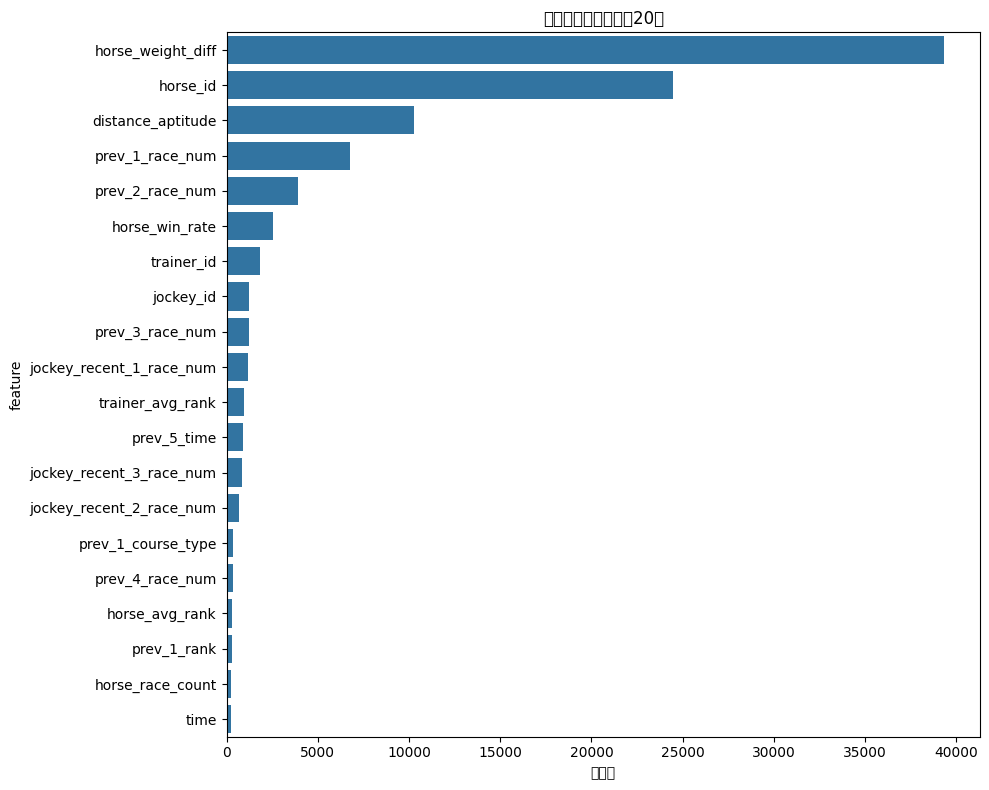

In [10]:
# 特徴量重要度を取得
importance = model.feature_importance(importance_type='gain')
feature_names = [f for f in rank_predictor.features.encoded_feature_names if f in val_df.columns]

importance_df = pd.DataFrame({
    'feature': feature_names[:len(importance)],
    'importance': importance
}).sort_values('importance', ascending=False)

print("特徴量重要度（上位20）:")
print(importance_df.head(20))

# 可視化
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(20), y='feature', x='importance')
plt.title('特徴量重要度（上位20）')
plt.xlabel('重要度')
plt.tight_layout()
plt.show()
